In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import matplotlib
plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize']=[14,8]

from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, make_scorer, roc_curve, 
                        
                            auc, average_precision_score, roc_auc_score)
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Classifier 1
from sklearn.ensemble import RandomForestClassifier # Classifier 2
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, make_scorer, roc_curve, 
                             auc, average_precision_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV # to optimize hyperparams
from sklearn.preprocessing import StandardScaler # to standardize numerical features
from sklearn.pipeline import Pipeline # to pass the standardization along with the classifier to GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

# EDA

In [2]:
df = pd.read_excel("reconciliation_exercise_dataset.xlsx")
df.sample(frac=1).head(n=5)

,is_correct_linking,payable_amount,payable_counter_party_name,payable_date_occurred,payable_direction,payable_document_type,payable_due_date,payable_due_date_with_early_payment_discount,payable_early_payment_discount_percent,payable_origin,payment_account_type,payment_amount,payable_reference,payment_counter_party_name,payment_date,payment_direction,payment_origin,payment_reference
680,0.0,447.78,"B. G. Weismüller et Comp., Gesellschaft mit be...",2018-04-21,incoming,Invoice,2018-05-21,NaT,NaN,supplier,bank_account,189.20,18—008—8074644,Begleitetes Leben für demenzbetroffene Mensche...,2018-07-30,outgoing,supplier,"Svwz+173-2018 Datum 28.07.2018, 14.24 Uhr1.Tan..."
400,1.0,55.00,Hängegleiterverein PHOENIX Berlin e.V.,2018-07-18,incoming,Receipt,2018-07-18,NaT,NaN,supplier,cash_register,55.00,NaN,KaMa Restaurant GmbH,2018-07-18,outgoing,supplier,"KaMa Restaurant GmbH , KaMa Restaurant GmbH"
1481,0.0,142.80,Kompaß-Antennen H. Schaefer,2018-03-22,incoming,Invoice,2018-04-21,NaT,NaN,supplier,bank_account,323.12,BSJ23784,FRAMA Zeitarbeit Martha Franz,2018-02-28,outgoing,supplier,Eref+Vk 60911000501 Bn 2211022256 Mref+Bsr.100...
1797,0.0,58.96,Intertrust Trustees GmbH,2018-08-13,incoming,Invoice,2018-09-12,NaT,NaN,supplier,bank_account,4.30,94527.0,Bildungs-und Jugendzentrum Wilhelmsburg e.V.,2018-09-12,outgoing,supplier,EREF+SEPADDDD000152267275-01 MREF+3763637-1-25...
968,0.0,108.29,K*STAR Communications GmbH,2018-04-01,incoming,Invoice,2018-05-01,NaT,NaN,supplier,bank_account,23.08,R1804-2416,centevo Handelsgesellschaft mbH,2018-07-30,outgoing,supplier,Referenz Rechnr. 100567552913 Mandat Kd0200084...


In [3]:
df['payable_document_type'].unique()

array(['Invoice', 'ForeignInvoice', 'Receipt', 'EntertainmentReceipt',
       'CommuteTicket', 'LatePaymentInvoice', 'CollectionReceipt',
       'Refund', datetime.datetime(2020, 6, 16, 0, 0), 'PaymentRequest',
       'PaymentContract'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   is_correct_linking                            2000 non-null   float64       
 1   payable_amount                                2000 non-null   float64       
 2   payable_counter_party_name                    2000 non-null   object        
 3   payable_date_occurred                         2000 non-null   datetime64[ns]
 4   payable_direction                             2000 non-null   object        
 5   payable_document_type                         2000 non-null   object        
 6   payable_due_date                              1836 non-null   datetime64[ns]
 7   payable_due_date_with_early_payment_discount  9 non-null      datetime64[ns]
 8   payable_early_payment_discount_percent        111 non-null    float6

In [5]:
# Check for Null values

df.isna().sum()

is_correct_linking                                 0
payable_amount                                     0
payable_counter_party_name                         0
payable_date_occurred                              0
payable_direction                                  0
payable_document_type                              0
payable_due_date                                 164
payable_due_date_with_early_payment_discount    1991
payable_early_payment_discount_percent          1889
payable_origin                                     0
payment_account_type                               0
payment_amount                                     0
payable_reference                                567
payment_counter_party_name                       153
payment_date                                       0
payment_direction                                  0
payment_origin                                     0
payment_reference                                  3
dtype: int64

# Preprocessing & Feature Engineering

### Dropping features

Columns whose values are the same

In [6]:
df['payable_direction'].value_counts(dropna=False)

incoming    2000
Name: payable_direction, dtype: int64

In [7]:
df['payable_origin'].value_counts(dropna=False)

supplier    2000
Name: payable_origin, dtype: int64

In [8]:
df.drop(columns=['payable_direction', 'payable_origin'], inplace=True)

Other columns whose features are unlikely to contribute

In [9]:
df.drop(columns=['payable_reference', 'payment_reference', 'payable_due_date_with_early_payment_discount', 'payable_early_payment_discount_percent'], inplace=True)

In [10]:
# 'payable_date_occurred' is incompatible with 'payment_date'.
    # Namely, for many of the transactions, the payment was supposedly recorded as 'done' before the transaction took place.

df[['payable_date_occurred', 'payable_due_date', 'payment_date']]

,payable_date_occurred,payable_due_date,payment_date
0,2018-02-28,2018-03-30,2018-04-25
1,2018-03-19,2018-04-18,2018-02-23
2,2018-03-01,NaT,2018-03-13
3,2018-06-09,2018-07-09,2018-07-03
4,2018-07-17,2018-07-17,2018-07-17
...,...,...,...
1995,2018-09-13,2018-09-13,2018-09-26
1996,2018-07-23,2018-07-23,2018-07-23
1997,2018-08-28,2018-09-27,2018-09-10
1998,2018-01-27,2018-01-27,2018-01-27


In [11]:
# A new feature to reflect the time difference between the due date and the actual payment date

df["time_diff"] = df['payable_due_date'] - df['payment_date']

In [12]:
# Dropping datetime columns

df.drop(columns=['payable_date_occurred', 'payable_due_date', 'payment_date'], inplace=True)

In [13]:
# Later - put in bins

df['time_diff'].value_counts()

0 days       168
-1 days       71
30 days       42
-2 days       40
28 days       36
            ... 
-114 days      1
-116 days      1
-115 days      1
-92 days       1
153 days       1
Name: time_diff, Length: 193, dtype: int64

### Dropping irrelevant rows

In [14]:
df['payable_document_type'].value_counts(dropna=False)

Invoice                 1165
Receipt                  531
ForeignInvoice           153
LatePaymentInvoice        45
EntertainmentReceipt      35
CommuteTicket             34
Refund                    30
CollectionReceipt          3
PaymentRequest             2
2020-06-16 00:00:00        1
PaymentContract            1
Name: payable_document_type, dtype: int64

In [15]:
# Remove the single row corresponding to the index hosting a datetime object in the `payable_document_type` column

remove_idx = df[df["payable_document_type"].map(type) != str].index
df.drop(index=remove_idx, inplace=True)

In [16]:
# Remove the rows corresponding to the null indices in the `payment_counter_party_name` column

remove_idx = df[df["payment_counter_party_name"].isna()].index
df.drop(index=remove_idx, inplace=True)

In [17]:
# Remove the rows corresponding to the null indices in the `time_diff` column

remove_idx = df[df["time_diff"].isna()].index
df.drop(index=remove_idx, inplace=True)

### Converting CamelCase to snake_case

In [18]:
def change_case(str):
     
    return ''.join(['_'+i.lower() if i.isupper() else i for i in str]).lstrip('_')

In [19]:
df['payable_document_type'] = df['payable_document_type'].apply(change_case)

### New feature 

In [20]:
df['time_diff'] = df['time_diff'].apply(str).str.split(' ').apply(lambda x: x[0]).astype(int)

In [21]:
df.head()

,is_correct_linking,payable_amount,payable_counter_party_name,payable_document_type,payment_account_type,payment_amount,payment_counter_party_name,payment_direction,payment_origin,time_diff
0,0.0,416.21,"""Mystica"" e.V.",invoice,bank_account,604.44,Kolde Stadtpalais GmbH & Co. KG,outgoing,supplier,-26
1,0.0,49.83,Rußlandhilfe e.V.,invoice,bank_account,19.87,Fernseh-Hartmann GmbH,outgoing,supplier,54
3,0.0,16.99,Klar Plus GmbH,foreign_invoice,credit_card,295.00,DOC-Gastro GmbH,outgoing,supplier,6
4,1.0,12.28,WEKA-Solvent-Vertriebs GmbH,receipt,cash_register,12.28,T-R RE-Fund I GmbH & Co. Retail 13 KG,outgoing,supplier,0
6,0.0,2.10,"Kleingartenverein ""Sonnenschein"" Werdau e.V.",receipt,cash_register,11.86,Klostermann Beteiligungs UG (haftungsbeschränkt),outgoing,supplier,1


In [22]:
columns = ['payable_counter_party_name', 'payment_counter_party_name']
df.drop(columns, inplace=True, axis=1)

In [23]:
df.columns

Index(['is_correct_linking', 'payable_amount', 'payable_document_type',
       'payment_account_type', 'payment_amount', 'payment_direction',
       'payment_origin', 'time_diff'],
      dtype='object')

In [24]:
df

,is_correct_linking,payable_amount,payable_document_type,payment_account_type,payment_amount,payment_direction,payment_origin,time_diff
0,0.0,416.21,invoice,bank_account,604.44,outgoing,supplier,-26
1,0.0,49.83,invoice,bank_account,19.87,outgoing,supplier,54
3,0.0,16.99,foreign_invoice,credit_card,295.00,outgoing,supplier,6
4,1.0,12.28,receipt,cash_register,12.28,outgoing,supplier,0
6,0.0,2.10,receipt,cash_register,11.86,outgoing,supplier,1
...,...,...,...,...,...,...,...,...
1994,1.0,30.80,invoice,bank_account,30.80,outgoing,supplier,25
1995,0.0,73.90,receipt,bank_account,535.92,outgoing,supplier,-13
1996,1.0,1.00,receipt,cash_register,1.00,outgoing,supplier,0
1997,0.0,55.34,invoice,bank_account,116.63,outgoing,supplier,17


In [25]:
df.columns

Index(['is_correct_linking', 'payable_amount', 'payable_document_type',
       'payment_account_type', 'payment_amount', 'payment_direction',
       'payment_origin', 'time_diff'],
      dtype='object')

In [26]:
X = df.drop(columns=['is_correct_linking'])
y = df["is_correct_linking"]

In [27]:
categorical_columns_subset = [
    'payable_document_type', 'payment_account_type', 'payment_direction',
       'payment_origin'
]

numerical_columns_subset = [
   'payable_amount', 'payment_amount','time_diff'
]

X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")

n_categorical_features = X.select_dtypes(include="category").shape[1]
n_numerical_features = X.select_dtypes(include="number").shape[1]

In [28]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)



In [29]:
pipe = Pipeline( [
    ('columntransform', one_hot_encoder),
    #("column_transform", column_transform)
    ("classify", RandomForestClassifier(random_state=1234, n_estimators=100))
])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1290e9f50>)])),
                ('classify', RandomForestClassifier(random_state=1234))])

In [31]:
f1_scorer = make_scorer(f1_score)

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [33]:
maxdepth_grid = [ 6, 8, 10, 12, 15, 20]
param_grid = [
    {'classify__max_depth': maxdepth_grid },
]
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid, verbose=1, 
                    return_train_score=True, scoring=f1_scorer)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1290e9f50>)])),
                                       ('classify',
                                        RandomForestClassifier(random_state=1234))]),
             n_jobs=1,
             param_grid=[{'classify__max_depth': [6, 8, 10, 12, 15, 20]}],
             return_train_score=True, scoring=make_scorer(f1_score), verbose=1)

In [34]:
y_predict_RFC = grid.predict(X_test)
display(pd.crosstab(columns=y_predict_RFC, index=y_test, normalize=True).round(3))
print('accuracy: {:.3f}'.format(accuracy_score(y_test, y_predict_RFC)))
print('f1-score: {:.3f}'.format(f1_score(y_test, y_predict_RFC)))

col_0,0.0,1.0
is_correct_linking,,
0.0,0.662,0.043
1.0,0.108,0.187


accuracy: 0.849
f1-score: 0.712


In [35]:
grid.cv_results_

{'mean_fit_time': array([0.19934425, 0.20427737, 0.26343231, 0.31802187, 0.26504087,
        0.22555518]),
 'std_fit_time': array([0.0175029 , 0.00948538, 0.05960716, 0.09670084, 0.07557346,
        0.01253874]),
 'mean_score_time': array([0.02452211, 0.02351103, 0.02645006, 0.03839464, 0.02303486,
        0.02172408]),
 'std_score_time': array([0.00461307, 0.00182111, 0.0040679 , 0.00868914, 0.00146487,
        0.00093437]),
 'param_classify__max_depth': masked_array(data=[6, 8, 10, 12, 15, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classify__max_depth': 6},
  {'classify__max_depth': 8},
  {'classify__max_depth': 10},
  {'classify__max_depth': 12},
  {'classify__max_depth': 15},
  {'classify__max_depth': 20}],
 'split0_test_score': array([0.46808511, 0.61818182, 0.63934426, 0.65      , 0.66129032,
        0.672     ]),
 'split1_test_score': array([0.41237113, 0.5982906 , 0.71532847, 0.74285714, 

In [36]:
result=pd.DataFrame({'param_classify__max_depth': grid.cv_results_["param_classify__max_depth"],'mean_test_score':
             
             grid.cv_results_["mean_test_score"], 'std_test_score': grid.cv_results_["std_test_score"],
            'mean_train_score':   grid.cv_results_["mean_train_score"],'std_train_score':grid.cv_results_["std_train_score"]
             })

In [37]:
result

,param_classify__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
0,6,0.459766,0.055566,0.540432,0.030785
1,8,0.612817,0.030781,0.814996,0.041463
2,10,0.701137,0.054918,0.918660,0.002620
3,12,0.732939,0.056858,0.964152,0.004713
4,15,0.730162,0.056088,0.991099,0.002982
5,20,0.728573,0.041573,0.999643,0.000713


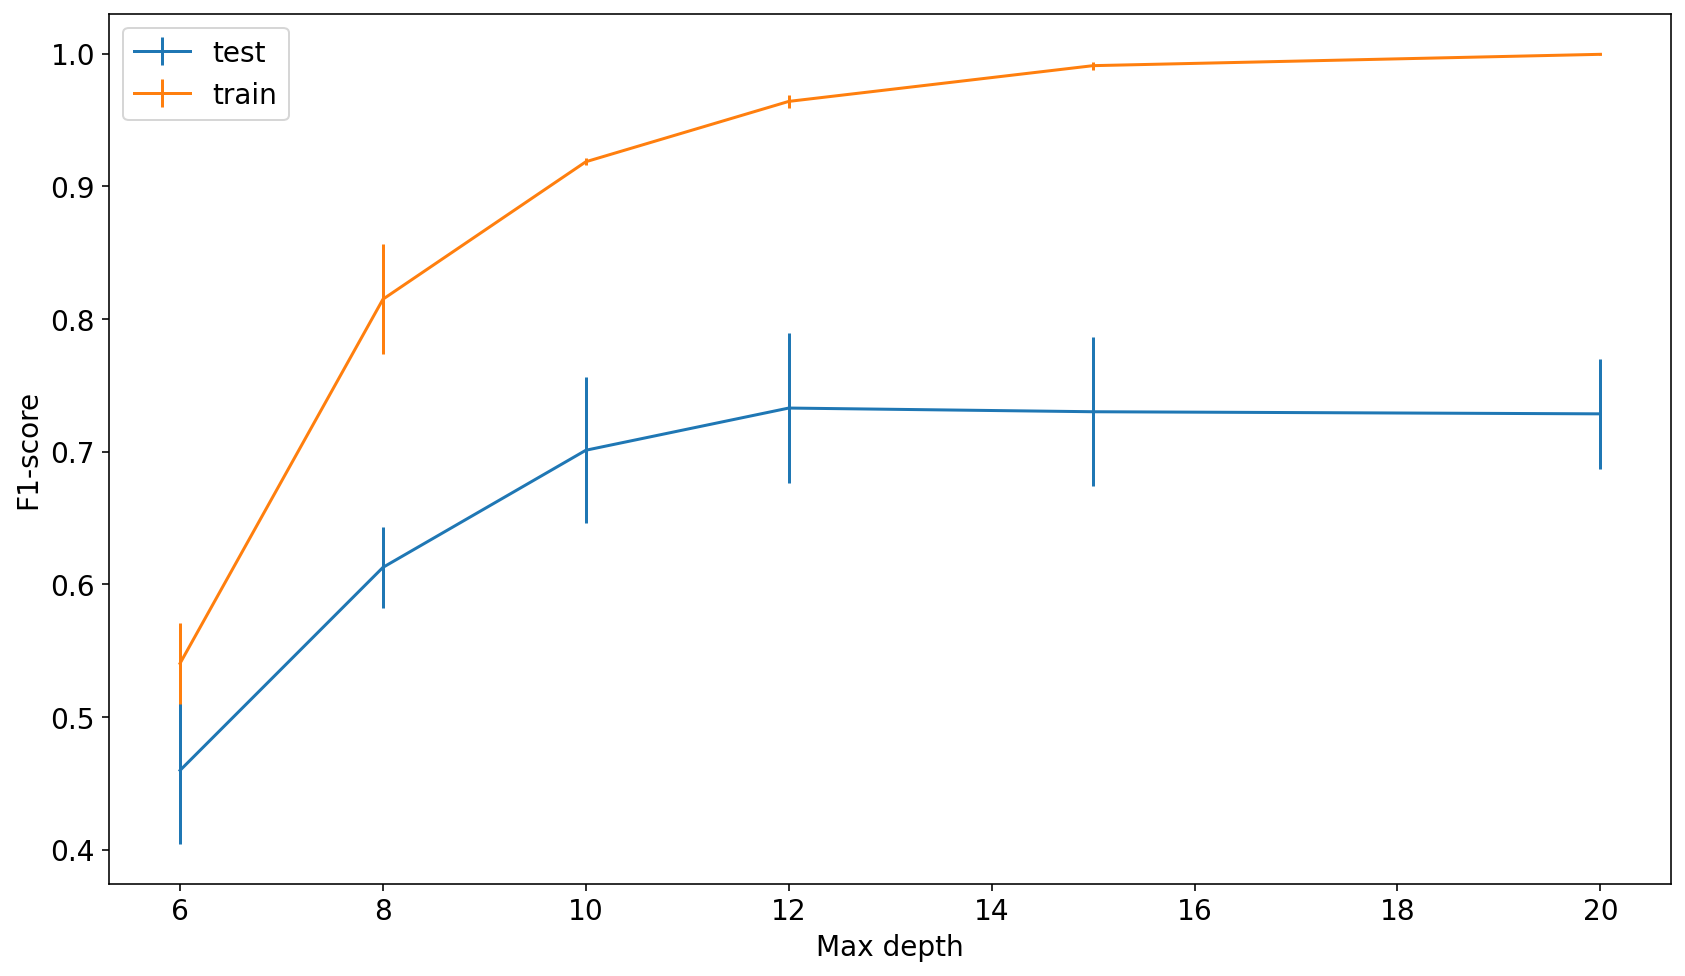

In [38]:
plt.errorbar(result['param_classify__max_depth'], result['mean_test_score'], 
         yerr=result['std_test_score'], label='test')
plt.errorbar(result['param_classify__max_depth'], result['mean_train_score'], 
         yerr=result['std_train_score'], label='train')
plt.xlabel('Max depth')
plt.ylabel('F1-score')
plt.legend();